In [1]:
from Chemometrics.basic import pload,plot_ConfusionMatrix,build_clf,cal_pct
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,GroupShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

# representative 样本

In [2]:
data = pload('./地沟油红外数据及标签.p')
ir = data['IR']
desc = data['descriptions']
labels = desc['地沟油含量']
label_ = ~labels.isnull()
rseed = 1
cond1 = ((~desc['品牌'].isnull()) & (desc['备注'].isnull()))
cond2 = np.isclose(desc['地沟油含量'],1)
cond3 = (desc['地沟油含量'].isnull() & desc['品牌'].isnull())
representatives = (cond1 | cond2 )| cond3
ir_n = ir[~representatives]
label_n = label_[~representatives]
ir = ir[representatives]
label = label_[representatives]
desc = desc[~desc.index.duplicated(keep='first')]

# group stratified split

In [3]:
# train test split
# stratified group split
train,test= train_test_split(label.index.unique(),test_size=.25,random_state=2)
X_train,X_test = ir[ir.index.isin(train)],ir[ir.index.isin(test)]
y_train,y_test = label[label.index.isin(train)],label[label.index.isin(test)]

# imbalanced learn  
- resampling to balance

In [4]:
# RandomOverSampler

In [5]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=rseed)

In [6]:
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [7]:
cv = GroupShuffleSplit(random_state=rseed).split(X_train,y_train,y_train.index)

In [8]:
clf = build_clf(X_resampled,y_resampled,cv=cv)

1.0

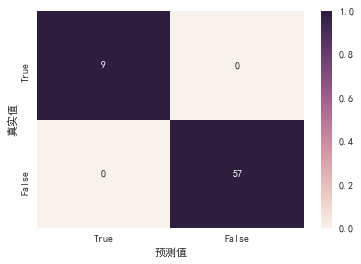

In [18]:
ptr = clf.predict(X_train)
cm_train = confusion_matrix(y_train,ptr,y_train.unique())
plot_ConfusionMatrix(cm_train,y_train.unique())
f1_score(ptr,y_train)

In [10]:
desc[desc.index.isin(y_train.index[ptr!= y_train])]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,


0.15384615384615383

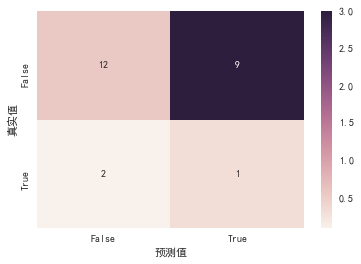

In [17]:
pt = clf.predict(X_test)
cm = confusion_matrix(y_test,pt,label_.unique())
plot_ConfusionMatrix(cm,label_.unique())
f1_score(pt,y_test)

In [12]:
desc[desc.index.isin(y_test.index[pt!= y_test])]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,
Y-025,NaN,花生油-2,NaN,NaN,NaN,花生油,NaN
Y-116,NaN,花生提-1,NaN,NaN,NaN,花生提,1.0
Y-301,胡姬花,古法花生油,压榨,-,NaN,花生油,NaN
Y-355,欧丽薇兰,橄榄油,冷榨,-,NaN,橄榄油,NaN
Y-402,贝蒂斯,橄榄油,压榨,-,NaN,橄榄油,NaN


In [13]:
# non representative sample prediction

In [14]:
pn = clf.predict(ir_n)

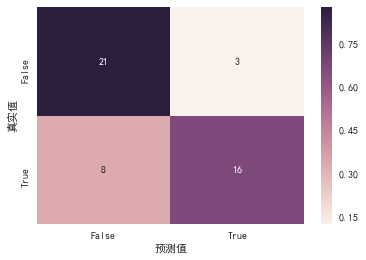

In [15]:
f1_score(label_n,pn)
ul = np.unique(pn)
cm = confusion_matrix(label_n,pn,ul)
plot_ConfusionMatrix(cm,ul)

In [16]:
desc[desc.index.isin(label_n.index[pn!=label_n])]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,
Y-172,NaN,玉米混-20-1,NaN,NaN,NaN,玉米混,0.2
Y-182,NaN,花生混-60-1,NaN,NaN,NaN,花生混,0.6
Y-217,NaN,花生混-20-1,NaN,NaN,NaN,花生混,0.2
Y-369,雪梨花,大豆油,浸出,是,1、昌平水屯粮油市场；,大豆油,NaN


In [26]:
#ROC 曲线
from sklearn.metrics import roc_curve
score = clf.predict_proba(ir_n)

In [29]:
 fpr, tpr,threshold = roc_curve(label_n,score[:,1])

In [30]:
plt.style.use('ggplot')

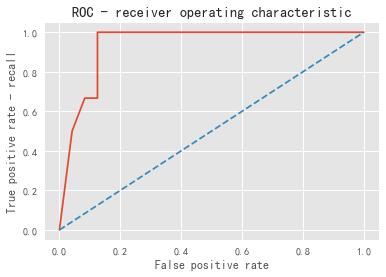

In [38]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate - recall')
plt.title('ROC - receiver operating characteristic')

In [ ]:
from sklearn.mod